In [18]:
# Imports

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import norm as normal_distribution, t as student_t_distribution
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
import numbers
from math import floor

In [24]:
# Konstanter

AXLES_COUNT = 'AxlesCount'
AXLE_WEIGHT_1 = 'AxleWeight1'
GROSS_WEIGHT = 'GrossWeight'
AXLE_DISTANCE_2 = 'AxleDistance2'
AXLE_DISTANCE_3 = 'AxleDistance3'
INDEX_NUMBER_OF_AXLES = 7
INDEX_AXLE_INFORMATION = 8
INDEX_GROSS_WEIGHT = 9
INDEX_WEIGHT_FIRST_SINGE_AXLE = 10
INDEX_LENGTH_VEHICLE = 16
INDEX_AXLE_DISTANCE_1 = 17
INDEX_AXLE_DISTANCE_2 = 18
INDEX_DATE_BWIM = 1
LOWER_WEIGHT_LIMIT = 5
UPPER_WEIGHT_LIMIT = 10
NUM_BINS = 20

In [20]:
def weights_first_axle_vehicles_with_6_axles_bwim(filepath: str) -> List:

    def is_valid_vehicle(row):
        
        def clean_value(value):
            try:
                if isinstance(value, numbers.Real):
                    return value
                return float(value.replace(',', '.'))
            except:
                return None
            
        try:
            axle_count = clean_value(row[INDEX_NUMBER_OF_AXLES])
            axle_distance_1 = clean_value(row[INDEX_AXLE_DISTANCE_1])
            axle_distance_2 = clean_value(row[INDEX_AXLE_DISTANCE_2])
            gross_weight = clean_value(row[INDEX_GROSS_WEIGHT])

            return(
                    axle_count == 6
                and axle_distance_1 > 2.8
                and axle_distance_1 < 3.6
                and axle_distance_2 > 1.3
                and axle_distance_2 < 1.8
                and gross_weight > 30
            )
        except:
            return False

    df = pl.read_csv(filepath, has_header=False, separator=';', truncate_ragged_lines=True, decimal_comma=True, ignore_errors=True)
    earliest_date = df.select(pl.nth(INDEX_DATE_BWIM)).min().item(0, 0)[0:10]
    latest_date = df.select(pl.nth(INDEX_DATE_BWIM)).max().item(0, 0)[0:10]
    weights = np.array([])

    for vehicle in df.iter_rows():
        if is_valid_vehicle(vehicle):
            weights = np.append(weights, vehicle[INDEX_WEIGHT_FIRST_SINGE_AXLE])

    # antar at dataen er normalfordelt, velger å filtrere ut avstikkere utenfor 2 * standardavviket
    filtered_weights = filter_weights(weights) # antar at dataen er normalfordelt, velger å filtrere ut avstikkere utenfor 2 * standardavviket

    return filtered_weights, earliest_date, latest_date

def weights_first_axle_vehicles_with_6_axles_kistler(filepath: str) -> List:

    df = pl.read_csv(filepath, separator=';', truncate_ragged_lines=True, skip_rows=6)
    df = df.filter((pl.col(GROSS_WEIGHT) != -1) & (pl.col( AXLES_COUNT) != 1))
    df = df.rename({col: col.replace(' ', '') for col in df.columns})
    df = df.with_columns(
        pl.col("StartTime").cast(pl.Datetime(time_unit='ms')).alias('unix_timestamp')
    )

    earliest_date = df['unix_timestamp'].min().date().isoformat()
    latest_date = df['unix_timestamp'].max().date().isoformat()

    vehicles_6_axles = df.filter(
          (pl.col(AXLES_COUNT) == 6) 
        & (pl.col(AXLE_DISTANCE_2) > 2.8) 
        & (pl.col(AXLE_DISTANCE_2) < 3.6) 
        & (pl.col(AXLE_DISTANCE_3) > 1.3) 
        & (pl.col(AXLE_DISTANCE_3) < 1.8)
    )

    weights = vehicles_6_axles.select(pl.col(AXLE_WEIGHT_1)).to_series().to_list()
    weights = np.array([float(weight) for weight in weights]) / 1000
    filtered_weights = filter_weights(weights) # antar at dataen er normalfordelt, velger å filtrere ut avstikkere utenfor 2 * standardavviket

    return filtered_weights, earliest_date, latest_date

def filter_weights(weights):
    threshold = 2 # Ettersom omtrent 96% av verdiene skal ligge innenfor 2 standardavvik fra forventningsverdien
    mean = np.mean(weights)
    std = np.std(weights)
    z_scores = (weights - mean) / std
    filtered_weights = weights[np.abs(z_scores) <= threshold]

    return filtered_weights

def extract_location(filepath):
    if 'Aanestad' in filepath and ('Vest' in filepath or 'vest' in filepath):
        return 'Ånestad(vestgående)'
    if 'Aanestad' in filepath and ('Ost' in filepath or 'ost' in filepath or 'Øst' in filepath or 'øst' in filepath):
        return 'Ånestad(østgående)'
    if 'Øysand' in filepath:
        return 'Øysand'
    if 'Skibotn' in filepath:
        return 'Skibotn'
    if 'Verdal' in filepath:
        return 'Verdal'
    if 'Sorbryn' in filepath:
        return 'Sørbryn'
    if 'Tangensvingen' in filepath:
        return 'Tangensvingen'
    if 'Fredrikstad' in filepath:
        return 'Fredrikstadbrua'

def plot_weight_data(datasets: tuple, data_source: str):

    intervals = np.linspace(LOWER_WEIGHT_LIMIT, UPPER_WEIGHT_LIMIT, NUM_BINS + 1)
    interval_labels = [f'{intervals[i]:.1f}-{intervals[i+1]:.1f}' for i in range(len(intervals)-1)]
    cols = ['location', 'startdate', 'enddate', 'mean', 'median', 'std'] + interval_labels
    rows = []

    n_rows = len(datasets)
    fig = plt.figure(figsize=(18, 7 * n_rows))
    gs = gridspec.GridSpec(n_rows, 2)

    for i, dataset in enumerate(datasets):
        try:
            row = i // 2
            location = extract_location(dataset)
            name_dataset = dataset.split('/')[-1]
            if data_source == 'BWIM':
                weights, startdate, enddate = weights_first_axle_vehicles_with_6_axles_bwim(dataset)
            else:
                weights, startdate, enddate = weights_first_axle_vehicles_with_6_axles_kistler(dataset)

            mean_weight = np.mean(weights)
            median_weight = np.median(weights)
            standard_deviation = np.std(weights)

            ax_hist = fig.add_subplot(gs[row, i % 2])
            ax_hist.hist(weights, bins=20, color='blue', edgecolor='black')
            ax_hist.set_title(f'Dataset: {name_dataset}', fontsize=12)
            ax_hist.set_ylabel('passeringer', fontsize=12)
            ax_hist.set_xlabel('Vekt (tonn)', fontsize=12)
            ax_hist.text(
                0.5, -0.11, 
                f'Gjennomsnittlig verdi: {mean_weight:.2f} | Median: {median_weight:.2f} | Standardavvik: {standard_deviation:.2f}', 
                ha='center', va='center', transform=ax_hist.transAxes, fontsize=12
            )

            bins = [0] * NUM_BINS
            bin_width = (UPPER_WEIGHT_LIMIT - LOWER_WEIGHT_LIMIT) / NUM_BINS
            for weight in weights:
                if LOWER_WEIGHT_LIMIT <= weight <= UPPER_WEIGHT_LIMIT:
                    bin_index = floor((weight - LOWER_WEIGHT_LIMIT) / bin_width)
                    bins[min(bin_index, NUM_BINS - 1)] += 1
            rows.append([location, startdate, enddate, mean_weight, median_weight, standard_deviation] + bins)

        except:
            pass

    df = pl.DataFrame(schema=cols, data=rows)
    df.write_csv('../resultater/vekt_første_aksel_bwim.csv' if data_source == 'BWIM' else '../resultater/vekt_første_aksel_kistler.csv')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.25)
    plt.show()

In [21]:
# Datasets

# Oppdatering: har droppet overlappende datasett
datasets_bwim = (
    # '../WIM-data/202210 okt22 14-20/Sorbryn_2022_newer_nswd_v0,9.csv',
    # '../WIM-data/202210 okt22 14-20/Sorbryn_2022_newer_nswd_v10022023.csv',
    '../WIM-data/202210 okt22 14-20/Tangensvingen_2022_newer_nswd.csv',
    # '../WIM-data/202210 okt22 14-20/Tangensvingen_2022_newer_nswd_v0,9.csv',
    # '../WIM-data/202210 okt22 14-20/Tangensvingen_2022_newer_nswd_v27122022.csv',
    '../WIM-data/202302 feb23 21-27/Sorbryn_feb2023_newer_nswd.csv',
    '../WIM-data/202302 feb23 21-27/Tangensvingen_feb2023_newer_nswd.csv',
    # '../WIM-data/202304 april23 17-23/Sorbryn_april2023_newer_nswd.csv', # Skaper error's der andre datasett fungerer
    # '../WIM-data/202304 april23 17-23/Tangensvingen_April2023_newer_nswd.csv', # Skaper error's der andre datasett fungerer
    '../WIM-data/202310 okt23 16-22/Sorbryn_oktober2023_newer_nswd.csv',
    '../WIM-data/202310 okt23 16-22/Tangensvingen_Oktober2023_newer_nswd.csv',
    '../WIM-data/202402 feb24 26feb-3mars/Sorbryn_february2024_newer_nswd.csv',
    '../WIM-data/202402 feb24 26feb-3mars/Tangensvingen_Februari2024_newer_nswd.csv',
    '../WIM-data/202404 april24 18-24/Sorbryn_april2024_newer_nswd.csv',
    '../WIM-data/202404 april24 18-24/Tangensvingen_April2024_newer_nswd.csv'
)

datasets_kistler = (
    '../WIM-data/Kistler_Øysand/20160808-31_Kistler Øysand_4913151-export(1).csv',
    '../WIM-data/Kistler_Øysand/20160901-30_Kistler Øysand_4913151-export(2).csv',
    '../WIM-data/Kistler_Øysand/20161001-31_Kistler Øysand_4913151-export(3)-fixed.csv',
    '../WIM-data/Kistler_Øysand/20161101-30_Kistler Øysand_4913151-export(4).csv',
    '../WIM-data/Kistler_Øysand/20161201-31_Kistler Øysand_4913151-export(5).csv',
    '../WIM-data/Kistler_Øysand/20170101-31_Kistler Øysand_4913151-export(6).csv',
    '../WIM-data/Kistler_Øysand/20170201-28_Kistler Øysand_4913151-export(7).csv',
    '../WIM-data/Kistler_Øysand/20170301-31_Kistler Øysand_4913151-export(8).csv',
    '../WIM-data/Kistler_Øysand/20170401-05_Kistler Øysand_4913151-export(9)-fixed.csv',
    '../WIM-data/Kistler_Øysand/20180316_1.3.1_Kistler Øysand_4913151-export(24).csv',
    '../WIM-data/Kistler_Øysand/20180401-30_Kistler Øysand_4796227-export(12).csv',
    '../WIM-data/Kistler_Øysand/20180501-31(21-26)_Kistler Øysand_4796227-export(13).csv',
    '../WIM-data/Kistler_Øysand/20180601-30(11-30)_Kistler Øysand_4796227-export(14).csv',
    '../WIM-data/Kistler_Øysand/20180701-31(01-11)_Kistler Øysand_4796227-export(15).csv',
    '../WIM-data/Kistler_Øysand/20180801-31(10-31)_Kistler Øysand_4796227-export(16).csv',
    '../WIM-data/Kistler_Øysand/20180901-30_Kistler Øysand 4796227-export(17).csv',
    '../WIM-data/Kistler_Skibotn/combinedFiles_E8_2018_kalibrert_4okt.csv',
    '../WIM-data/Kistler_Skibotn/combinedFiles_E8_2019.csv',
    '../WIM-data/Kistler_Skibotn/combinedFiles_E8_2020.csv',
    '../WIM-data/Kistler_Verdal/20150513-20150531_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20150601-20150630_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20150701-20150731_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20150801-20150831_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20150901-20150930_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20151001-20151031_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20151101-20151130_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20151201-20151231_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160101-20160131_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160201-20160229_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160301-20160331_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160401-20160430_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160501-20160531_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Aanestad/20221014-20 Kistler_R3_ostg.csv',
    '../WIM-data/Kistler_Aanestad/20221014-20 Kistler_R3_vestg.csv',
    # '../WIM-data/Kistler_Aanestad/20240123-20240612_R3 østgående.csv',
    # '../WIM-data/Kistler_Aanestad/20240122-20240612_R3 vestgående.csv',
    # '../WIM-data/Kistler_Aanestad/20231001-20240123_Aanestad_Ostgående.csv',
    # '../WIM-data/Kistler_Aanestad/20231001-20240123_Aanestad_Vestgående.csv'
)

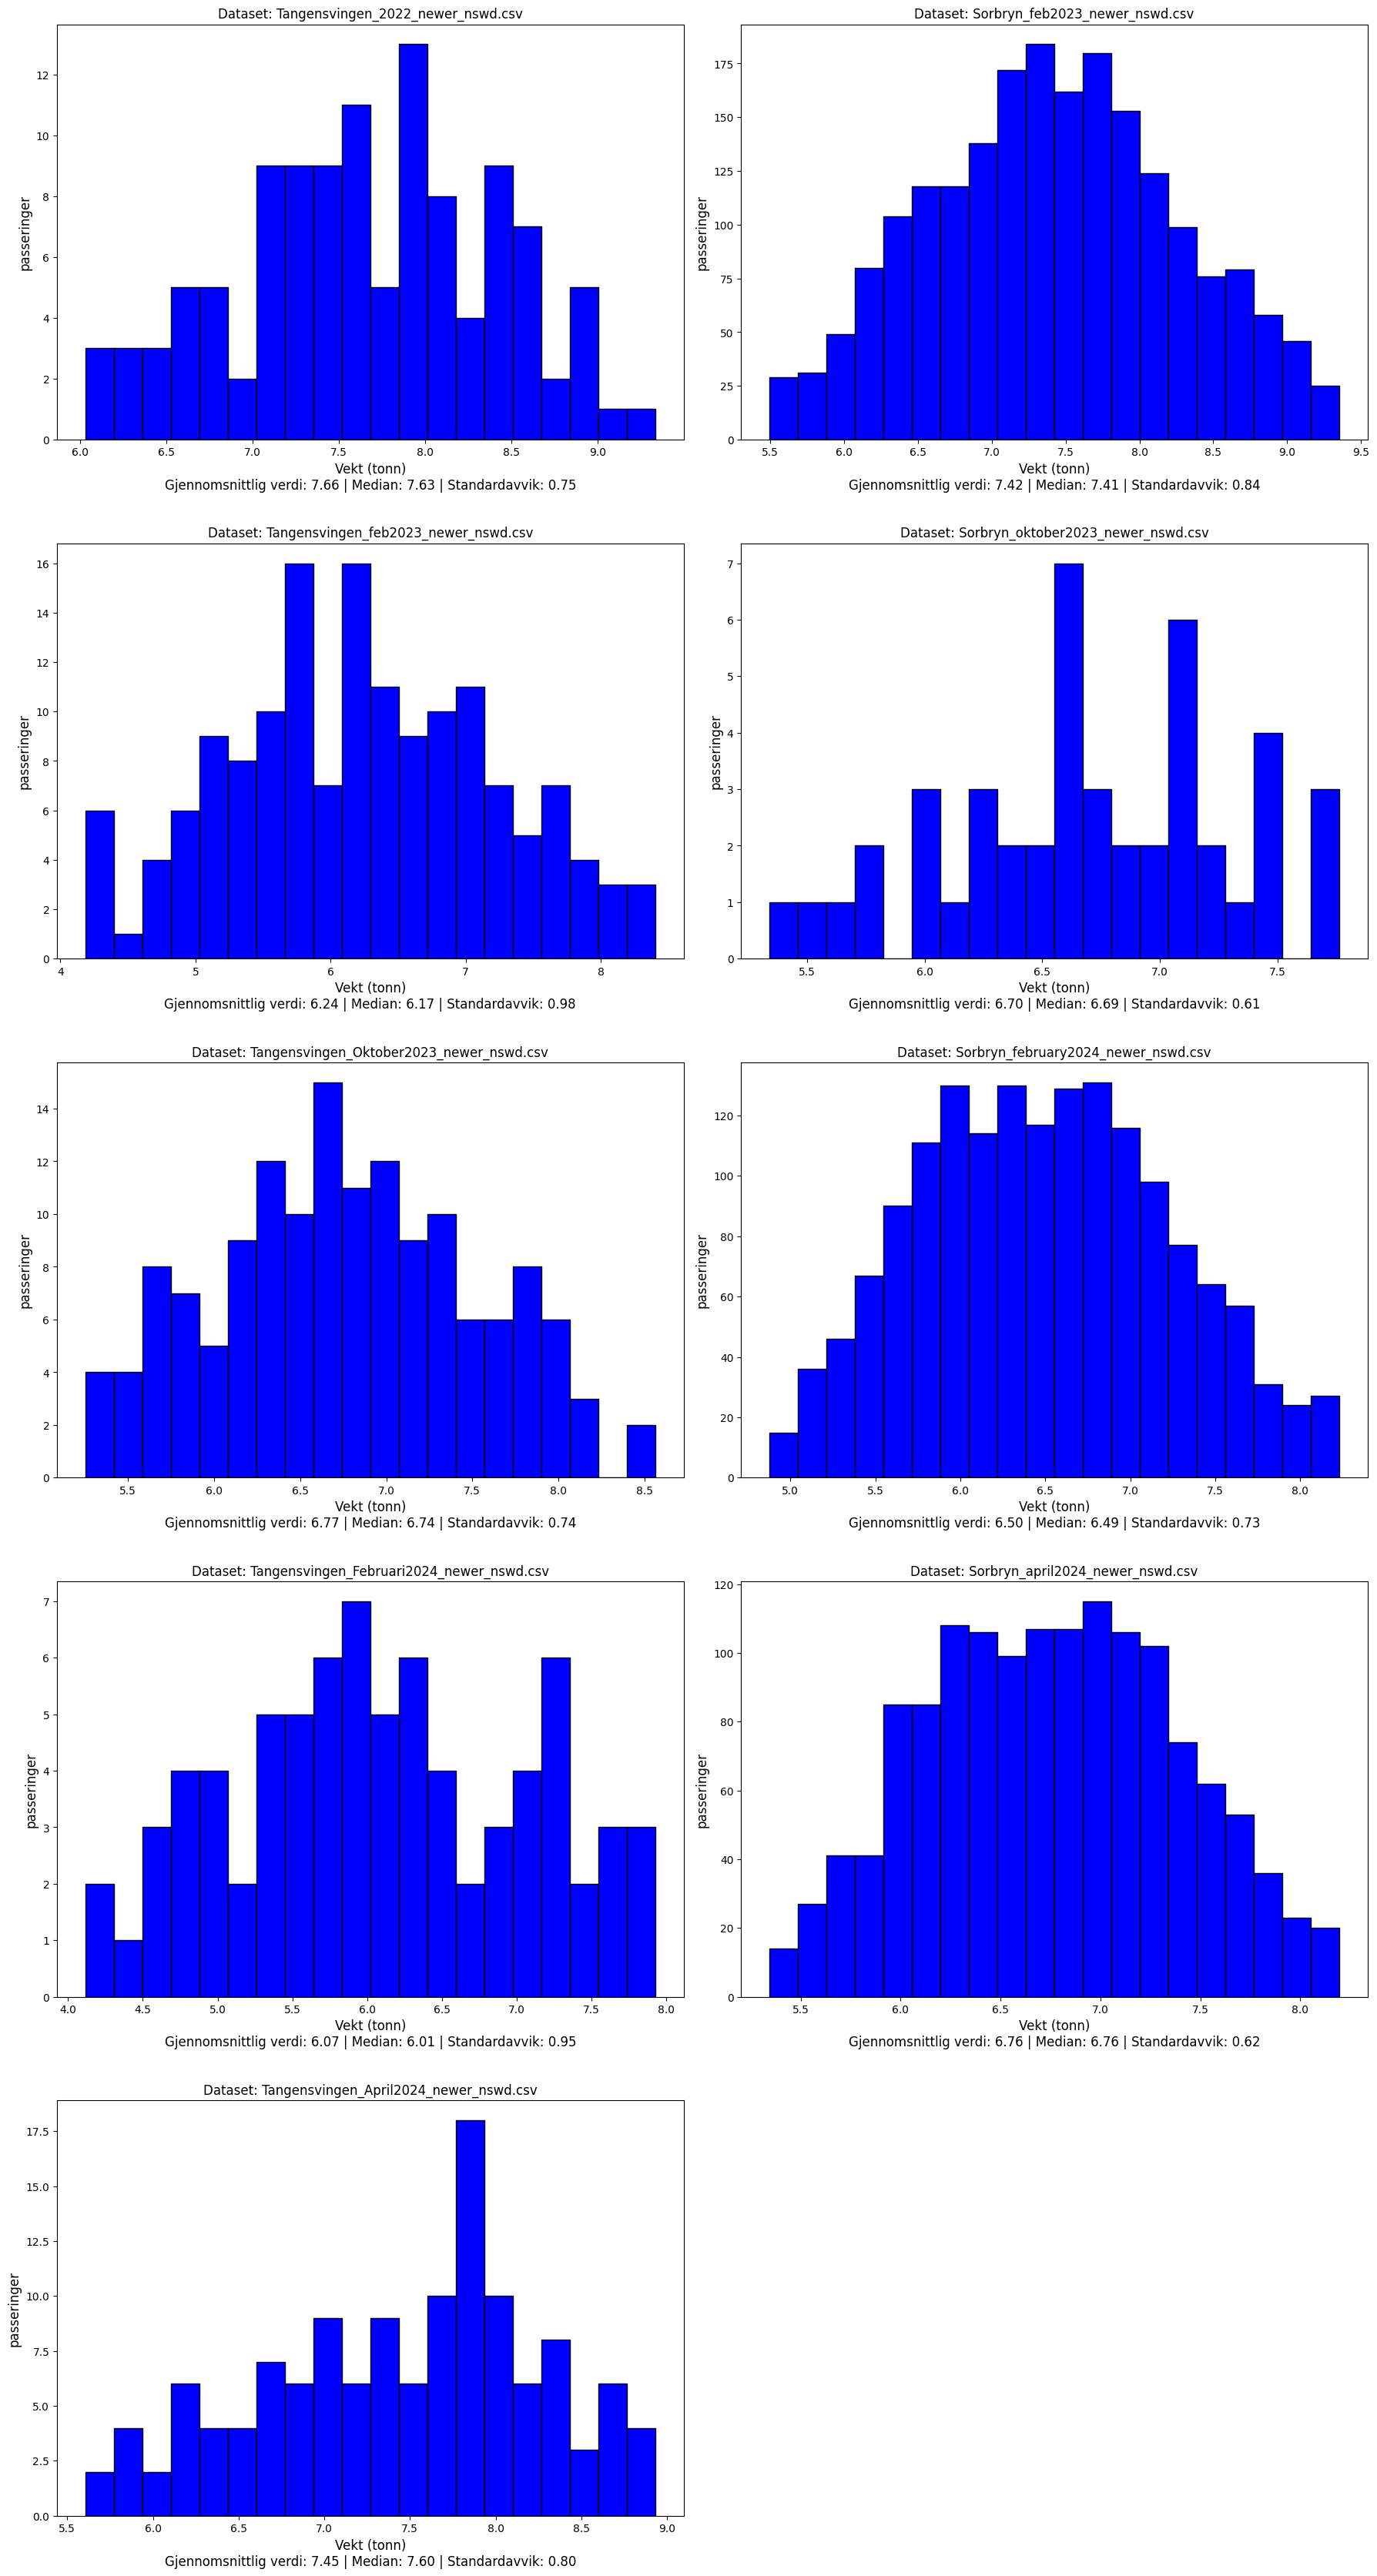

In [22]:
plot_weight_data(datasets_bwim, 'BWIM')

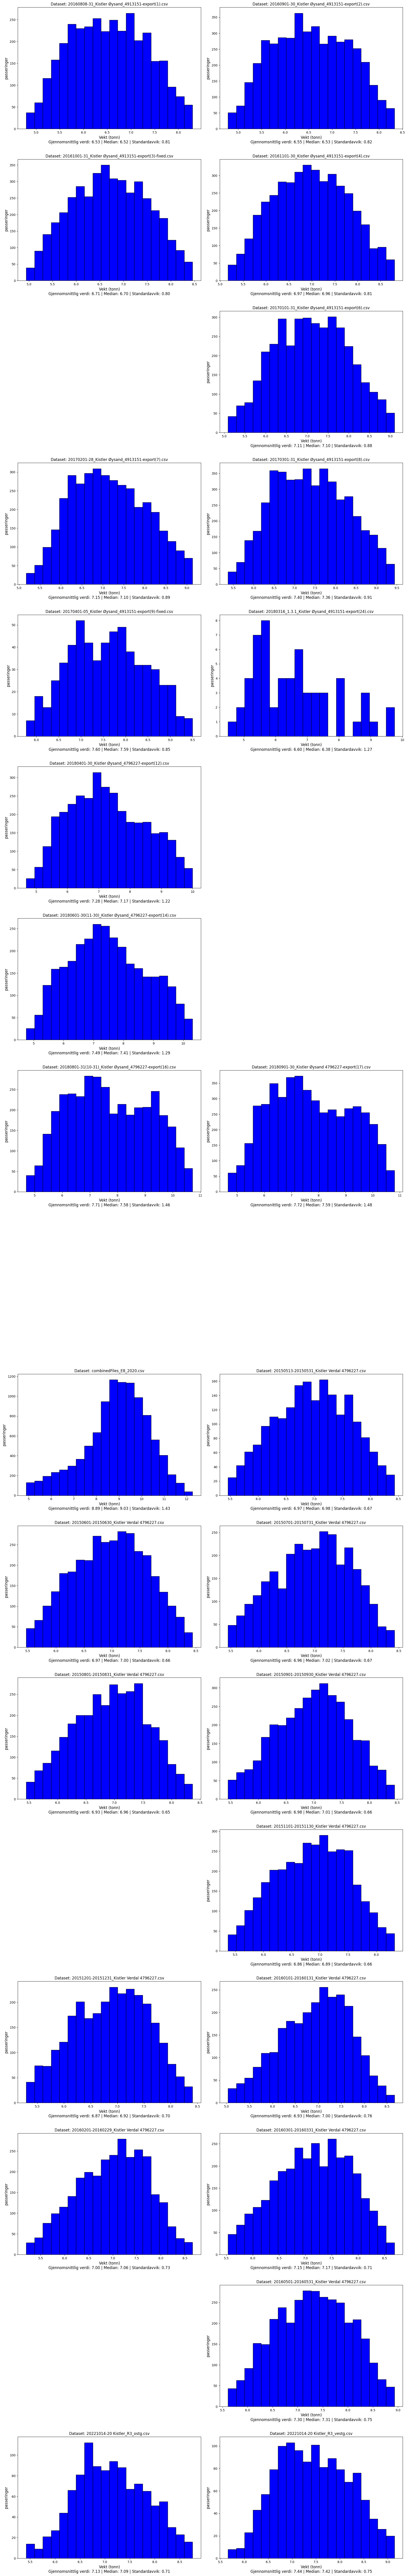

In [23]:
plot_weight_data(datasets_kistler, 'Kistler')